In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WWZvMTFk2DSCDPOhtUd1")
project = rf.workspace("polygence-project").project("trashnet-a-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection")
version = project.version(20)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-20 in coco:: 100%|██████████| 6048/6048 [00:01<00:00, 5145.18it/s]


In [ ]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

# We use the COCO API to load COCO-format annotations.
from pycocotools.coco import COCO

########################################
# 1) COCO DATASET DEFINITION (No Augment)
########################################

class CocoDataset(Dataset):
    """
    A simple COCO dataset loader that returns images + bounding boxes for object detection.
    No data augmentation included.
    """
    def __init__(self, img_dir, ann_file, transforms=None):
        """
        img_dir   : directory where all the images are stored
        ann_file  : path to the COCO JSON annotation file
        transforms: optional; if you wanted to apply transforms
        """
        super().__init__()
        self.img_dir = img_dir
        self.transforms = transforms

        # Load the COCO dataset
        self.coco = COCO(ann_file)

        # Get the image IDs
        self.img_ids = list(self.coco.imgs.keys())

        # Build a mapping from cat_id to our internal label index
        # We'll treat 'background' as class 0 (if we want).
        # The rest will be 1..N for the actual categories.
        self.cat_ids = sorted(self.coco.getCatIds())

        # Map each COCO category ID to a new index (1..N)
        # (This ensures they are consecutive and starts at 1.)
        self.cat2label = {cat_id: i+1 for i, cat_id in enumerate(self.cat_ids)}

        print(f"Total images: {len(self.img_ids)}")
        print(f"Total categories: {len(self.cat_ids)}")

    def __getitem__(self, idx):
        """
        Returns: image (as a tensor) and target dict
          target = {
             "boxes": FloatTensor[N, 4] (x1, y1, x2, y2),
             "labels": Int64Tensor[N]
          }
        """
        # Get image ID
        img_id = self.img_ids[idx]
        # Load image metadata
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.imgs[img_id]

        # Image file path
        file_name = img_info['file_name']
        img_path = os.path.join(self.img_dir, file_name)

        # Read image
        img_array = plt.imread(img_path)  # shape: (H, W, 3) typically
        if len(img_array.shape) == 2:
            # Grayscale => stack to 3 channels
            img_array = np.stack([img_array]*3, axis=-1)
        elif img_array.shape[2] == 4:
            # RGBA => drop alpha
            img_array = img_array[..., :3]

        # Convert to tensor (C,H,W)
        image = F.to_tensor(img_array)

        # Parse each annotation to get bounding boxes + labels
        boxes = []
        labels = []
        for ann in anns:
            # Some COCO datasets mark crowd regions or stuff with iscrowd=1
            if ann.get("iscrowd", 0) == 1:
                continue

            # ann["bbox"] is [x, y, width, height] in COCO
            x, y, w, h = ann["bbox"]
            x1 = x
            y1 = y
            x2 = x + w
            y2 = y + h

            # If the annotation is out of bounds, we might clip to the image size
            # for safety:
            _, H, W = image.shape
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(W, x2)
            y2 = min(H, y2)

            # Skip invalid box
            if x2 <= x1 or y2 <= y1:
                continue

            cat_id = ann["category_id"]
            # Convert cat_id to our label index
            label = self.cat2label[cat_id]

            boxes.append([x1, y1, x2, y2])
            labels.append(label)

        if len(boxes) == 0:
            # If there's no box, let's put one dummy box and label = 0
            boxes = [[0,0,1,1]]
            labels = [0]  # "background"

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            # "image_id": torch.tensor([img_id])
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.img_ids)

    def get_num_classes(self):
        """
        Return total number of categories + 1 for background (if you used class 0 as background).
        """
        return 1 + len(self.cat_ids)

########################################
# 2) CREATE DATALOADERS
########################################

train_img_dir = "/content/TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-20/train"
train_ann_file = "/content/TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-20/train/_annotations.coco.json"
val_img_dir   = "/content/TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-20/valid"
val_ann_file  = "/content/TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-20/valid/_annotations.coco.json"

train_dataset = CocoDataset(img_dir=train_img_dir, ann_file=train_ann_file)
val_dataset   = CocoDataset(img_dir=val_img_dir,   ann_file=val_ann_file)

# If GPU can handle bigger batch size, you can increase from 4.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Determine num_classes from the dataset (including background=0)
num_classes = train_dataset.get_num_classes()
print(f"Number of classes (including background): {num_classes}")

########################################
# 3) MODEL DEFINITION
########################################

def get_model(num_classes):
    # Use newer API that loads default weights:
    weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # Replace the classification head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

########################################
# 4) EVALUATION (mAP) UTILITIES
########################################

def compute_iou(boxA, boxB):
    """
    Compute IoU between boxA and each box in boxB.
    boxA: shape (4,) -> [x1, y1, x2, y2]
    boxB: shape (N,4) -> [x1, y1, x2, y2]
    Returns: np.array of shape (N,) with IoU for each box in boxB
    """
    xA = np.maximum(boxA[0], boxB[:, 0])
    yA = np.maximum(boxA[1], boxB[:, 1])
    xB = np.minimum(boxA[2], boxB[:, 2])
    yB = np.minimum(boxA[3], boxB[:, 3])

    interArea = np.maximum(0, xB - xA) * np.maximum(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1])
    iou = interArea / (boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_map(model, data_loader, device, iou_thresholds=None, score_threshold=0.0, num_classes=None):
    """
    Evaluate mean Average Precision:
      - For IoU in [0.5:0.95] with step=0.05 (COCO style),
      - Also calculates mAP@0.50
    """
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
    if num_classes is None:
        raise ValueError("num_classes must be specified (including background).")

    model.eval()
    predictions = defaultdict(list)  # {class_id: [(score, box, GT_boxes_for_that_image), ...], ...}
    total_gts   = defaultdict(int)   # {class_id: total # of GT boxes for that class}

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for out, tgt in zip(outputs, targets):
                # predicted
                pred_boxes  = out["boxes"].cpu().numpy()
                pred_labels = out["labels"].cpu().numpy()
                pred_scores = out["scores"].cpu().numpy()

                # ground-truth
                gt_boxes  = tgt["boxes"].cpu().numpy()
                gt_labels = tgt["labels"].cpu().numpy()

                # Count how many GT boxes per class
                for gt_label in gt_labels:
                    total_gts[int(gt_label)] += 1

                # Filter out predictions below threshold
                keep = pred_scores >= score_threshold
                pred_boxes  = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                # Sort predictions by descending confidence
                inds = np.argsort(-pred_scores)
                pred_boxes  = pred_boxes[inds]
                pred_labels = pred_labels[inds]
                pred_scores = pred_scores[inds]

                # Store predictions in the dictionary
                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    # skip background label=0
                    if label == 0:
                        continue
                    # store the GT boxes for that label
                    gt_boxes_same_label = gt_boxes[gt_labels == label]
                    predictions[int(label)].append((score, box, gt_boxes_same_label))

    # Now compute the AP for each class at each IoU threshold
    AP_per_class = {th: np.zeros(num_classes) for th in iou_thresholds}
    valid_classes = [c for c in range(1, num_classes)]  # exclude background=0

    for class_id in valid_classes:
        class_preds = predictions[class_id]
        if len(class_preds) == 0:
            # no predictions for that class
            for th in iou_thresholds:
                AP_per_class[th][class_id] = 0.0
            continue

        # Sort by descending confidence
        class_preds.sort(key=lambda x: x[0], reverse=True)

        for th in iou_thresholds:
            TP = np.zeros(len(class_preds), dtype=np.float32)
            FP = np.zeros(len(class_preds), dtype=np.float32)

            for idx_pred, (score, pred_box, gt_boxes_same_label) in enumerate(class_preds):
                if len(gt_boxes_same_label) == 0:
                    # no matching GT box => false positive
                    FP[idx_pred] = 1
                else:
                    ious = compute_iou(pred_box, gt_boxes_same_label)
                    max_iou_idx = np.argmax(ious)
                    max_iou_val = ious[max_iou_idx]

                    # If IoU >= threshold => true positive (assuming that GT box not used yet).
                    # For a rigorous check, we'd track whether that GT box was matched before.
                    # This simplified approach can slightly overcount FPs if multiple preds match the same GT.
                    if max_iou_val >= th:
                        TP[idx_pred] = 1
                    else:
                        FP[idx_pred] = 1

            acc_TP = np.cumsum(TP)
            acc_FP = np.cumsum(FP)
            recalls    = acc_TP / (total_gts[class_id] + 1e-6)
            precisions = acc_TP / (acc_TP + acc_FP + 1e-6)

            # Insert (r=0,p=1) at start
            recalls    = np.concatenate(([0.0], recalls))
            precisions = np.concatenate(([1.0], precisions))
            for i in range(len(precisions)-1, 0, -1):
                precisions[i-1] = max(precisions[i-1], precisions[i])

            # Area under PR curve
            ids = np.where(recalls[1:] != recalls[:-1])[0]
            ap = 0.0
            for i in ids:
                ap += (recalls[i+1] - recalls[i]) * precisions[i+1]
            AP_per_class[th][class_id] = ap

    # Now average AP across classes at each IoU threshold
    mAPs = []
    for th in iou_thresholds:
        valid_aps = [AP_per_class[th][c] for c in valid_classes]
        mAPs.append(np.mean(valid_aps))

    map_50 = mAPs[0]  # iou_thresholds[0] = 0.5
    map_50_95 = np.mean(mAPs)
    return map_50, map_50_95


########################################
# 5) TRAINING LOOP
########################################

def train_model(model, train_loader, val_loader, device, num_epochs, num_classes):
    model.to(device)

    # Example: SGD + momentum
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.005,
        momentum=0.9,
        weight_decay=1e-4
    )

    # Optional scheduler that decays LR every 10 epochs by factor of 0.1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Prepare a DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=[
        "epoch", "time",
        "train/box_loss", "train/cls_loss", "train/dfl_loss",
        "val/box_loss", "val/cls_loss", "val/dfl_loss",
        "metrics/precision(B)", "metrics/recall(B)",
        "metrics/mAP@50", "metrics/mAP@50-95",
        "lr/pg0"
    ])

    for epoch in range(num_epochs):
        start = time()
        model.train()

        # Accumulate training losses
        train_box_loss = 0.0
        train_cls_loss = 0.0
        train_dfl_loss = 0.0

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss_box = loss_dict.get("loss_box_reg", torch.tensor(0.0))
            loss_cls = loss_dict.get("loss_classifier", torch.tensor(0.0))
            loss_sum = sum(loss_dict.values())

            train_box_loss += loss_box.item()
            train_cls_loss += loss_cls.item()
            train_dfl_loss += loss_sum.item()

            optimizer.zero_grad()
            loss_sum.backward()
            optimizer.step()

        # Step the scheduler
        scheduler.step()

        # Compute average losses
        train_box_loss /= len(train_loader)
        train_cls_loss /= len(train_loader)
        train_dfl_loss /= len(train_loader)

        # Validation
        model.eval()
        val_box_loss, val_cls_loss, val_dfl_loss = 0.0, 0.0, 0.0
        precision, recall = 0.0, 0.0

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Evaluate validation losses
                model.train()  # put temporarily in train mode for val losses
                loss_dict_val = model(images, targets)
                val_box_loss += loss_dict_val.get("loss_box_reg", torch.tensor(0.0)).item()
                val_cls_loss += loss_dict_val.get("loss_classifier", torch.tensor(0.0)).item()
                val_dfl_loss += sum(loss_dict_val.values()).item()
                model.eval()

                # Quick batch-level precision/recall at IoU=0.5
                outputs = model(images)
                batch_tp, batch_fp, batch_fn = 0, 0, 0
                iou_thresh = 0.5
                for i, out in enumerate(outputs):
                    preds_boxes  = out["boxes"].cpu().numpy()
                    preds_labels = out["labels"].cpu().numpy()
                    gt_boxes     = targets[i]["boxes"].cpu().numpy()
                    gt_labels    = targets[i]["labels"].cpu().numpy()

                    matched = set()
                    for j, pbox in enumerate(preds_boxes):
                        ious = compute_iou(pbox, gt_boxes)
                        max_iou_idx = np.argmax(ious)
                        max_iou_val = ious[max_iou_idx]
                        if max_iou_val >= iou_thresh and preds_labels[j] in gt_labels:
                            batch_tp += 1
                            matched.add(max_iou_idx)
                        else:
                            batch_fp += 1
                    batch_fn += len(gt_boxes) - len(matched)

                # Summation of batch-level precision/recall
                batch_precision = batch_tp / (batch_tp + batch_fp + 1e-6)
                batch_recall    = batch_tp / (batch_tp + batch_fn + 1e-6)
                precision += batch_precision
                recall    += batch_recall

        precision /= len(val_loader)
        recall    /= len(val_loader)
        val_box_loss /= len(val_loader)
        val_cls_loss /= len(val_loader)
        val_dfl_loss /= len(val_loader)

        # Compute overall mAP@0.5 and mAP@0.5:0.95
        map_50, map_50_95 = evaluate_map(
            model, val_loader, device,
            iou_thresholds=np.arange(0.5, 1.0, 0.05),
            score_threshold=0.0,
            num_classes=num_classes
        )

        end = time()

        new_row = {
            "epoch": epoch + 1,
            "time": round(end - start, 2),
            "train/box_loss": train_box_loss,
            "train/cls_loss": train_cls_loss,
            "train/dfl_loss": train_dfl_loss,
            "val/box_loss": val_box_loss,
            "val/cls_loss": val_cls_loss,
            "val/dfl_loss": val_dfl_loss,
            "metrics/precision(B)": precision,
            "metrics/recall(B)": recall,
            "metrics/mAP@50": map_50,
            "metrics/mAP@50-95": map_50_95,
            "lr/pg0": optimizer.param_groups[0]["lr"]
        }

        # Append to metrics DataFrame
        metrics_df.loc[len(metrics_df)] = new_row
        print(metrics_df.tail(1).to_string(index=False))

    return model, metrics_df

########################################
# 6) MAIN SCRIPT
########################################
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = get_model(num_classes)
    num_epochs = 100

    model, metrics_df = train_model(model, train_loader, val_loader, device, num_epochs, num_classes)

    metrics_filename = "training_metrics_coco_fasterrcnn.csv"
    model_filename   = "fasterrcnn_coco_model.pth"
    metrics_df.to_csv(metrics_filename, index=False)
    torch.save(model.state_dict(), model_filename)

    print(f"Training complete. Metrics saved to {metrics_filename}, model saved to {model_filename}.")


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Total images: 5278
Total categories: 7
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total images: 499
Total categories: 7
Number of classes (including background): 8
Using device: cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 216MB/s]
The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)


 epoch   time  train/box_loss  train/cls_loss  train/dfl_loss  val/box_loss  val/cls_loss  val/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP@50  metrics/mAP@50-95  lr/pg0
     1 217.26        0.148999        0.258923        0.426263      0.029158      0.058735      0.108948              0.165645             0.9924        0.407436           0.322643   0.005
 epoch   time  train/box_loss  train/cls_loss  train/dfl_loss  val/box_loss  val/cls_loss  val/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP@50  metrics/mAP@50-95  lr/pg0
     2 214.91        0.081552        0.224685        0.318824      0.030352      0.045243      0.096047              0.229249             0.9864        0.590871           0.446009   0.005
 epoch   time  train/box_loss  train/cls_loss  train/dfl_loss  val/box_loss  val/cls_loss  val/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP@50  metrics/mAP@50-95  lr/pg0
     3 215.58        0.071058        0.207719        0.29022

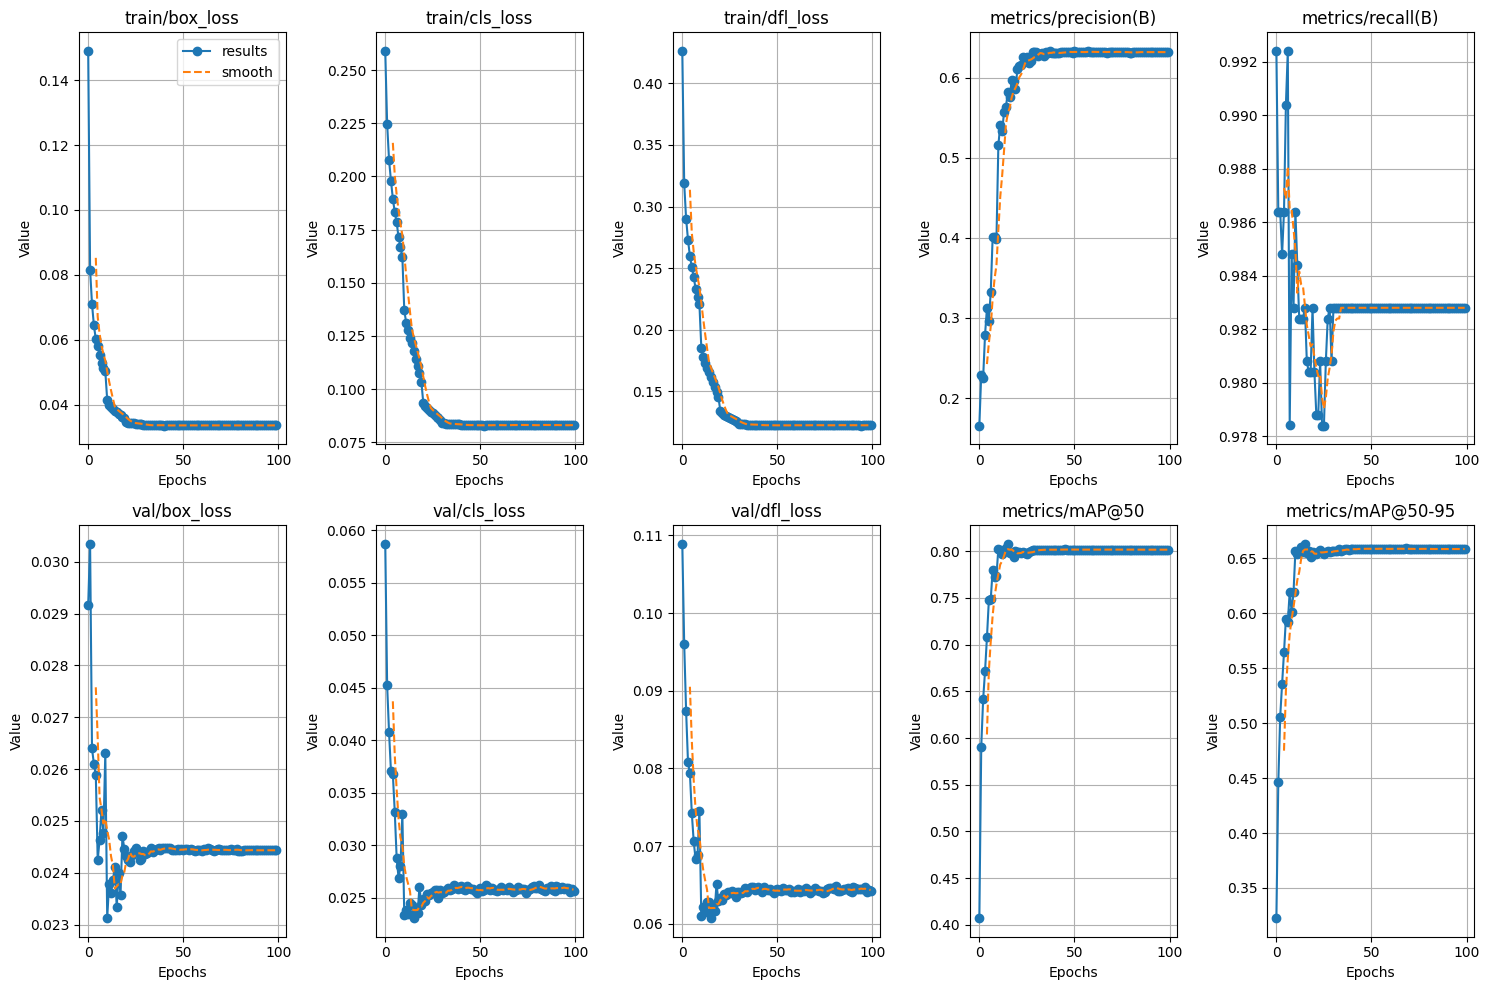

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = '/content/training_metrics_coco_fasterrcnn.csv'
df = pd.read_csv(file_path)

# List of metrics to plot
metrics = [
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
    'metrics/mAP@50', 'metrics/mAP@50-95'
]

# Create a grid layout for the plots
plt.figure(figsize=(15, 10))

# Loop through metrics and assign positions
for idx, metric in enumerate(metrics):
    plt.subplot(2, 5, idx + 1)  # 2 rows, 5 columns grid
    if metric in df.columns:
        plt.plot(df[metric], label='results', marker='o')
        plt.plot(df[metric].rolling(window=5).mean(), label='smooth', linestyle='--')
    else:
        plt.text(0.5, 0.5, f"{metric} not found", ha='center', va='center')

    plt.title(metric)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

# Download the CSV file
files.download('/content/training_metrics_coco_fasterrcnn.csv')

# Download the model weights file
files.download('/content/fasterrcnn_coco_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>